# Shifting particles based on their 2D class average

In some cases you may wish to shift particles based on their 2D class average. This notebook works through the process necessary to do this.

# Before starting

Here we assume that a 2D Classification job has been performed with some particle stack. In this case, we're using data from [EMPIAR 10880](https://www.ebi.ac.uk/empiar/EMPIAR-10880/). We run a 2D Classification job with 100 classes and get the following class averages:

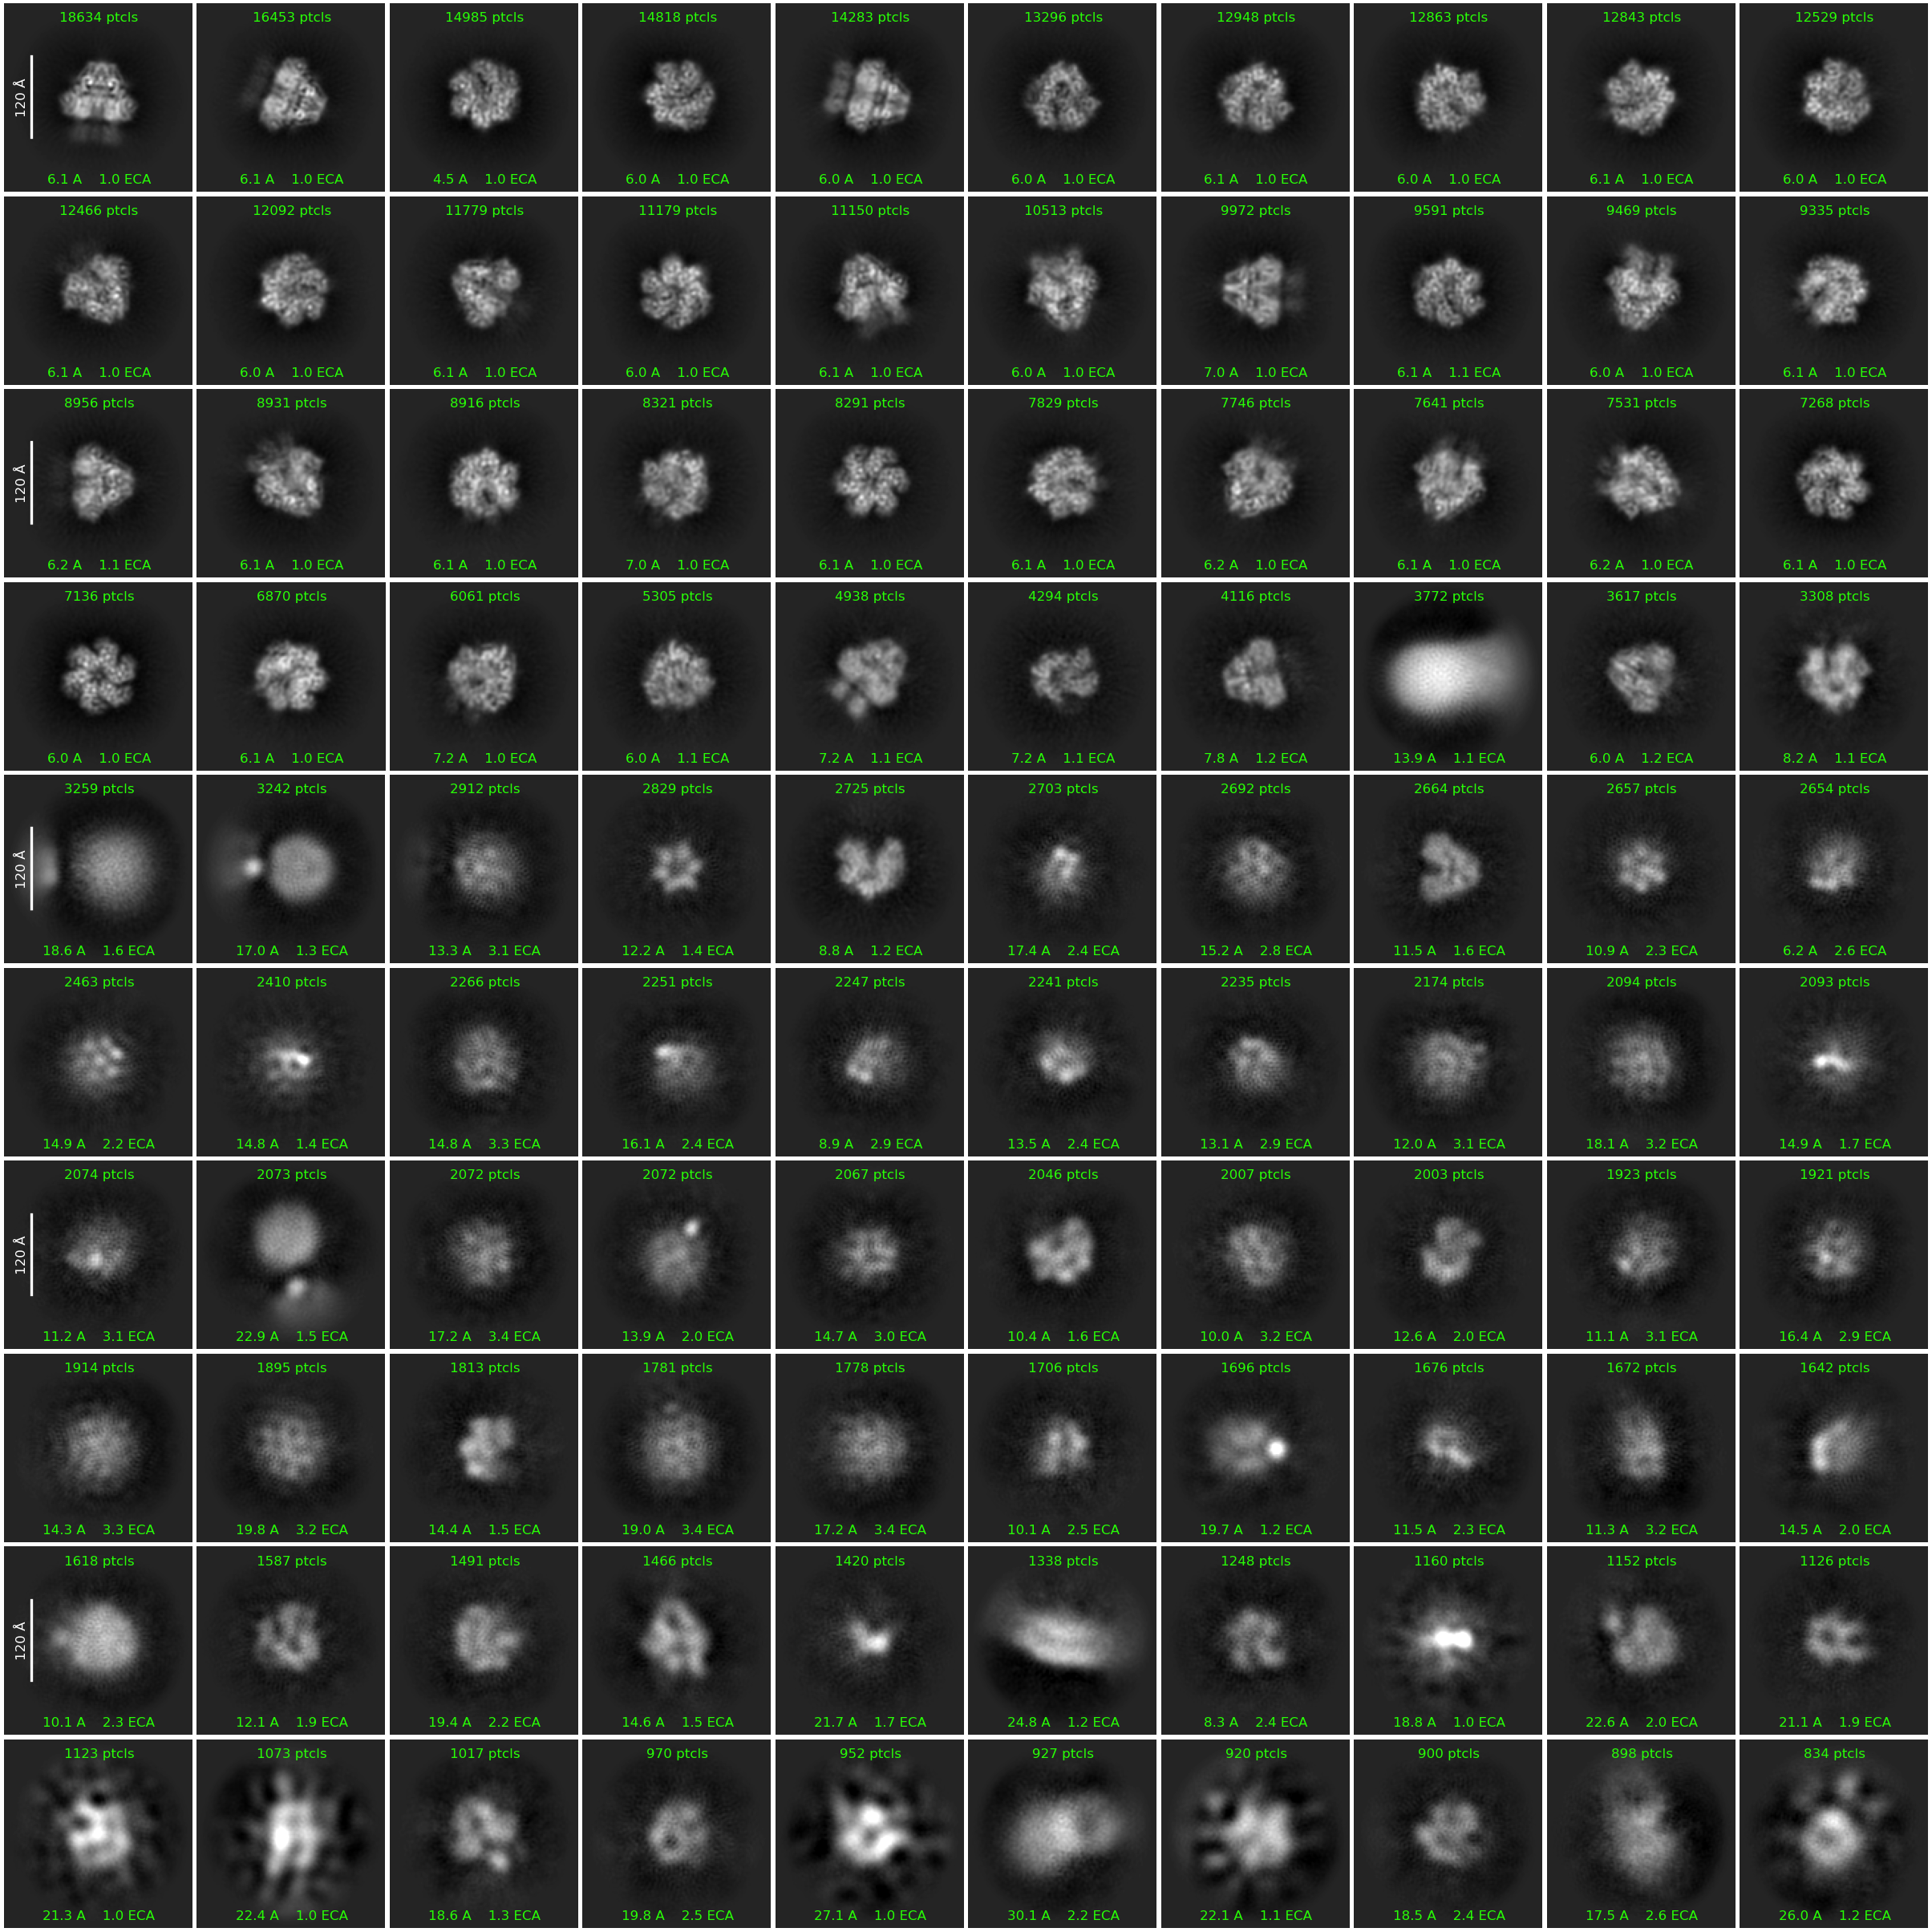

Let's say our goal is to shift the first three classes 40 Å to the right, and the second three classes 30 Å up and 30 Å to the right.
To do this, we first must load the particles from CryoSPARC into python.

In [1]:
# tools version 4.7
from cryosparc.tools import CryoSPARC
import json
from pathlib import Path
import numpy as np

# for more information on instance credentials, see this repo's README
with open(Path("~/instance-credentials/dev2-info.json").expanduser(), "r") as f:
    cs = CryoSPARC(**json.load(f))

puid = "P10"
wuid = "W3"
juid = "J17"
particles_title = "particles" # the name of the particles output

project = cs.find_project(puid)
job = project.find_job(juid)
unshifted_particles = job.load_output(particles_title)

The first important point is that the class numbers stored in `alignments2D/class` are *not sorted by particle count*. Assuming you used the default settings in 2D classifications to sort by particle count (as we have here), the first class in the image above is not class 0. We can sort the class averages by their particle count using numpy.

In [4]:
# class_nums is the class number, like 0, 1, 2, etc.
# class counts is the particles in that class.
class_nums, class_counts = np.unique(unshifted_particles["alignments2D/class"], return_counts = True)
print(f"Class nums: {class_nums[:3]}...")
# sorted classes has the class indices in order of particle counts
sorted_classes = class_nums.take( # class_nums.take([0, 4]) would return the 0th and 4th element of class_nums
    # np.argsort gives the order of indices of the input array.
    # So np.argsort([2, 1, 3]) == [1, 0, 2], (the sorted *indices*),
    # because the *elements* should be in the order [1, 2, 3]
    np.argsort(class_counts)[::-1] # we reverse the argsort because we want the biggest number first
)
print(f"Sorted class nums: {sorted_classes[:3]}...")

Class nums: [0 1 2]...
Sorted class nums: [84 89 20]...


So now we know that the class average in the top-left (the "first" class) in the image above is actually class 84 in the particles dataset. We can now shift it by the desired amount: 40 Å to the right. CryoSPARC stores particle shifts in pixels, so we need to convert our desired shifts into the particles' pixel size.

In [5]:
# pixel size
apix = unshifted_particles["alignments2D/psize_A"][0]
# right 40, up 0 is in angstroms, but CryoSPARC shifts are in pixels
shift = np.array([40, 0]) / apix

Now we can simply add this shift to the desired subset of the particles.
More information about the query function is [available in the documentation](https://tools.cryosparc.com/api/dataset.html#cryosparc.dataset.Dataset.query).

In [6]:
first_three_classes = unshifted_particles.query({"alignments2D/class": sorted_classes[:3]})
first_three_classes["alignments2D/shift"] += shift

Now `first_three_classes` has all of the particles from the largest three classes, with their poses shifted. We can save this dataset back into CryoSPARC as an external job.

In [7]:
project.save_external_result(
    workspace_uid=wuid,
    dataset=first_three_classes,
    type="particle",
    name="particles_shifted",
    slots=["alignments2D"], # only provide the slot we changed
    passthrough=(juid, particles_title) # all the other slots are passed through from the input
)

'J58'

If we look at J58, we see a `particles_shifted` output. This contains the particles we modified above.

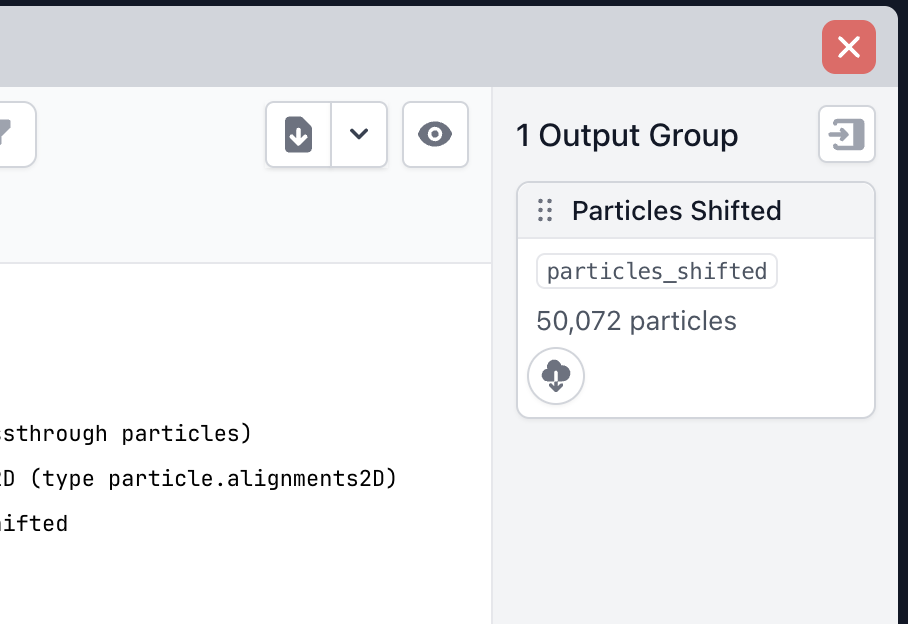

If we create a [Reconstruct 2D Classes](https://guide.cryosparc.com/processing-data/all-job-types-in-cryosparc/particle-curation/job-reconstruct-2d-classes) job using these particles, we should see the first three classes shifted to the right by 40 &Aring;.
However, the class averages instead look like very blurry copies of the input:

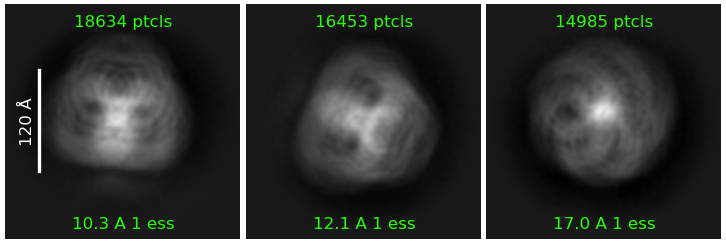

This is because we shifted the particles 40 &Aring; to the right in the *particles'* reference frame, but we want to shift them in the *class averages'* reference frame. To do this, we must rotate our shift vector ([40, 0]) using the opposite of each particle's pose (the angle it's rotated by in the image). We can then add these rotated shifts to the particles' poses and save them in a new external job.

In [ ]:
fixed_first_three_classes = unshifted_particles.query({"alignments2D/class": sorted_classes[:3]})
poses = -1 * fixed_first_three_classes["alignments2D/pose"]
rotated_shift = np.hstack([
    (shift[0] * np.cos(poses) - shift[1] * np.sin(poses)).reshape(-1, 1),
    (shift[0] * np.sin(poses) + shift[1] * np.cos(poses)).reshape(-1, 1),
])
fixed_first_three_classes["alignments2D/shift"] += rotated_shift

project.save_external_result(
    workspace_uid=wuid,
    dataset=fixed_first_three_classes,
    type="particle",
    name="particles_shifted",
    slots=["alignments2D"],
    passthrough=(juid, particles_title)
)

'J60'

Now when we run a Reconstruct 2D Classes job, the class averages look correct, but they are not shifted.

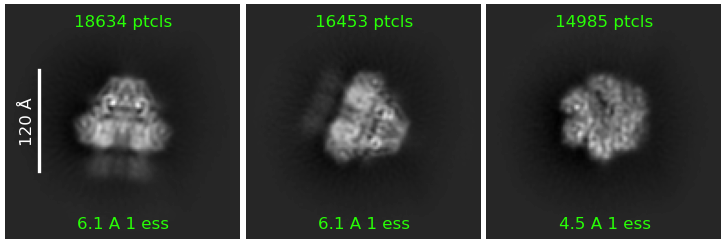

This is because Reconstruct 2D Classes re-centers class averages by default. We need to turn off two parameters: `Use circular mask on 2D classes` and `Re-center 2D classes`. Turnig off the circular mask ensures that the edge of the shifted class average will not be clipped.

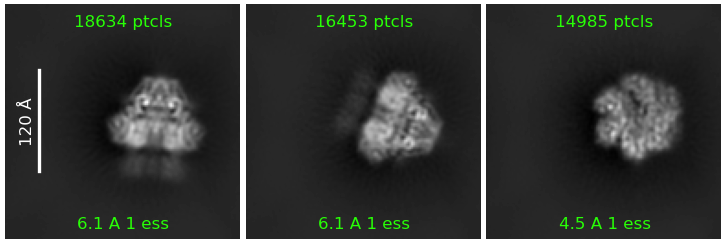

We have finally shifted the particles and confirmed this by checking their class averages!